這份 Notebook 示範 OpenAI Embedding API、語意搜尋、K-means 分群，最後透過 LLM 幫每一群訂出主題

In [21]:
# from google.colab import userdata
# openai_api_key = userdata.get('openai_api_key')

In [1]:
import requests
import json
from pprint import pp

In [6]:
# Import necessary libraries
## 設定 OpenAI API Key 變數
from dotenv import load_dotenv
import os

# Load the environment variables from .env file
load_dotenv()

# Access the API key
openai_api_key = os.getenv('OPENAI_API_KEY')



In [7]:
def get_completion(messages, model="gpt-4o-mini", temperature=0, max_completion_tokens=4000):
  payload = { "model": model, "temperature": temperature, "messages": messages, "max_completion_tokens": max_completion_tokens }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/chat/completions', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["choices"][0]["message"]["content"]
  else :
    return obj["error"]

## Embeddings API

官方指南
* https://platform.openai.com/docs/guides/embeddings/what-are-embeddings
* https://platform.openai.com/docs/guides/embeddings/use-cases 推薦看一下 Use Cases

## 定義一個輔助函數可以拿到 embedding vector

In [8]:
def get_embeddings(input, dimensions = 1536, model="text-embedding-3-small"):
  payload = { "input": input, "model": model, "dimensions": dimensions }
  headers = { "Authorization": f'Bearer {openai_api_key}', "Content-Type": "application/json" }
  response = requests.post('https://api.openai.com/v1/embeddings', headers = headers, data = json.dumps(payload) )
  obj = json.loads(response.text)
  if response.status_code == 200 :
    return obj["data"][0]["embedding"]
  else :
    return obj["error"]

In [9]:
x = get_embeddings("test")
print(x)

[-0.009876498, 0.0015304419, 0.015627984, -0.05478792, -0.0064124567, -0.012935652, 0.0096481, -0.013551636, 0.028625926, 0.00786244, 0.03180966, -0.006592407, 0.0038308632, 0.010132581, 0.014077644, 0.044683024, -0.05990958, -0.0024206764, -0.051188916, 0.036488365, 0.036100782, 0.024334807, 0.03992126, -0.04360332, 0.0344397, -0.019573046, -0.013973827, 0.010617062, 0.031200599, -0.041582342, 0.058746826, -0.028875088, -0.0013963445, -0.038813878, 0.05520319, 0.004097328, 0.023615004, 0.018922457, -0.005668432, -0.0039381413, -0.041499287, -0.044987556, 0.0113645485, 0.027227852, 0.030010158, -0.018728664, -0.03441202, -0.038620085, 0.04842045, 0.027836913, -0.031781975, -0.0027788465, 0.04822666, 0.07020827, 0.019337727, 0.023933379, -0.035159502, 0.019932946, 0.018548714, 0.0053327554, -0.0023185892, -0.018770192, 0.03839861, 0.0054954025, -0.03197577, -0.060020316, 0.012236615, 0.03150513, 0.0004663133, 0.021469444, 0.045928832, 0.011842108, -0.01285952, 0.016721528, 0.008720664, 

In [10]:
len(x)

1536

In [11]:
x = get_embeddings("test", 8)
print(x)

[-0.15956798, 0.02472633, 0.2524909, -0.88517183, -0.10360178, -0.20899269, 0.1558779, -0.21894473]


In [12]:
x = get_embeddings("test", 1)
print(x)

[-1.0]


In [17]:
import pandas as pd

df = pd.read_csv(r"D:\python_workspace\github\iSpan_LLM-NLP-cookbooks\Langchain_scratch\prompt-engineering\books-dataset-33.csv")

In [19]:
df.head()

,title,description,category
0,絕對會 Python 用場! 驚人的程式妙用,✨ 想不到Python還可以這麼玩!? ✨\r\n\r\n✨ 用天馬行空的範例 讓你陷入Py...,程式語言
1,AI世代必備！Python × ChatGPT 高效率工作術：從網路爬蟲到辦公室自動化超實務,最全面的 ChatGPT × Python 應用手冊！\r\n\r\n \r\n\r\nAI...,程式語言
2,Python 風格徹底研究｜超詳實、好理解的 Python 必學主題 (Dead Simpl...,多位Python官方社群的大神技術審校和推薦\r\n教您寫出Python風格的專業程式碼\r...,程式語言
3,Python 大數據專案 X 工程 X 產品 資料工程師的升級攻略 2/e,★☆★☆★ 獨家解析知名大數據專案，FinMind，帶你一窺大數據產品的發展過程，打造專屬個...,程式語言
4,AI 時代的管理數學：使用 R語言實作,如果你主要關注統計分析、數據可視化、線性代數、初等微積分，\r\n\r\n \r\n\r\n...,人工智慧


### 拿書名跟描述拿計算 embedding

In [23]:
df['embeddings'] = None

for index, row in df.iterrows():
    df.at[index, 'embeddings'] = get_embeddings( f"{row['title']} {row['description']}" )

# 要跑一段時間，因為每一筆都呼叫 API 算出 embedding 向量

df

,title,description,category,embeddings
0,絕對會 Python 用場! 驚人的程式妙用,✨ 想不到Python還可以這麼玩!? ✨\r\n\r\n✨ 用天馬行空的範例 讓你陷入Py...,程式語言,"[0.025438976, 0.020128483, -0.041755896, 0.008..."
1,AI世代必備！Python × ChatGPT 高效率工作術：從網路爬蟲到辦公室自動化超實務,最全面的 ChatGPT × Python 應用手冊！\r\n\r\n \r\n\r\nAI...,程式語言,"[-0.0009054362, 0.008443421, 0.018184328, -0.0..."
2,Python 風格徹底研究｜超詳實、好理解的 Python 必學主題 (Dead Simpl...,多位Python官方社群的大神技術審校和推薦\r\n教您寫出Python風格的專業程式碼\r...,程式語言,"[-0.0053023645, 0.026380599, -0.020956732, -0...."
3,Python 大數據專案 X 工程 X 產品 資料工程師的升級攻略 2/e,★☆★☆★ 獨家解析知名大數據專案，FinMind，帶你一窺大數據產品的發展過程，打造專屬個...,程式語言,"[-0.002149683, -0.021061938, 0.039701696, 0.00..."
4,AI 時代的管理數學：使用 R語言實作,如果你主要關注統計分析、數據可視化、線性代數、初等微積分，\r\n\r\n \r\n\r\n...,人工智慧,"[-0.02211929, 0.059633106, 0.014918623, -0.008..."
5,史上最強 Python 入門邁向頂尖高手之路王者歸來 3/e (全彩印刷),天瓏購書獨家贈送習題解答\r\n\r\n史上最強\r\n\r\nPython入門\r\n\r...,程式語言,"[0.010593332, -0.0077877464, -0.0037191482, -0..."
6,AI世代：從政治哲學反思人工智慧的衝擊,人臉辨識、數位威權、同溫層效應……\r\n科技是中立的嗎？\r\n科技真的能帶來更好的未來嗎...,人工智慧,"[0.021665882, 0.00035356806, 0.0024535384, 0.0..."
7,電子商務與 ChatGPT：物聯網 ‧ KOL直播 ‧ 區塊鏈‧ 社群行銷 ‧ 大數據 ‧...,\r\n\t電子商務是利用網路進行銷售或交換產品與服務，並達到降低成本要求的現代化經營模式，...,物聯網 IoT,"[-0.037117645, 0.030888999, -0.03709646, 0.018..."
8,權力與進步：科技變革與共享繁榮之間的千年辯證,全球獨家中文版！《金融時報》年度選書\r\n\r\n關心AI時代人類命運的必讀之作\r\n\...,人工智慧,"[0.055803783, -0.0025401874, 0.015217494, 0.03..."
9,電腦軟體設計丙級技能檢定學術科｜適用 C++ (第三版),依據勞動部勞動力發展署技能檢定中心最新啟用之學術科試題規劃解題\r\n\r\n術科篇\r\n...,考試認證,"[0.044044524, 0.04007815, -0.019437212, -0.041..."


## 來根據用戶查詢，找最相似的內容

https://github.com/openai/openai-cookbook/blob/main/examples/Semantic_text_search_using_embeddings.ipynb

* 又叫做 語意搜尋
* 也可以拿來做相似性內容推薦、產品推薦

稍後的 colab 我們會改用 ANN 算法，以及 Vector Database 幫我們處理。
這裡我們自幹，逐筆計算相似距離，找到最近的。

In [21]:
import numpy as np

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


### 每一筆都計算相似度，然後排序取分數最高的

In [24]:
def search_similar(df, query, n=3):
    query_embedding = get_embeddings(query)
    df["similarity"] = df['embeddings'].apply(lambda x: cosine_similarity(x, query_embedding))

    results = (
        df.sort_values("similarity", ascending=False)
        .head(n)
    )

    return results

# 根據用戶問題，找最相似的書
results = search_similar(df, "怎樣用 Python 做資料分析", n=5)
results


,title,description,category,embeddings,similarity
3,Python 大數據專案 X 工程 X 產品 資料工程師的升級攻略 2/e,★☆★☆★ 獨家解析知名大數據專案，FinMind，帶你一窺大數據產品的發展過程，打造專屬個...,程式語言,"[-0.002149683, -0.021061938, 0.039701696, 0.00...",0.496976
1,AI世代必備！Python × ChatGPT 高效率工作術：從網路爬蟲到辦公室自動化超實務,最全面的 ChatGPT × Python 應用手冊！\r\n\r\n \r\n\r\nAI...,程式語言,"[-0.0009054362, 0.008443421, 0.018184328, -0.0...",0.424388
2,Python 風格徹底研究｜超詳實、好理解的 Python 必學主題 (Dead Simpl...,多位Python官方社群的大神技術審校和推薦\r\n教您寫出Python風格的專業程式碼\r...,程式語言,"[-0.0053023645, 0.026380599, -0.020956732, -0....",0.418222
5,史上最強 Python 入門邁向頂尖高手之路王者歸來 3/e (全彩印刷),天瓏購書獨家贈送習題解答\r\n\r\n史上最強\r\n\r\nPython入門\r\n\r...,程式語言,"[0.010593332, -0.0077877464, -0.0037191482, -0...",0.385709
20,文科生也可以輕鬆學會 Web Scraper 網路爬蟲與 Power Automate X ...,不用動手寫程式，讓Web Scraper爬蟲 X Power Automate自動化工具幫你...,Data Science,"[-0.0022526754, 0.040428016, 0.006242414, 0.01...",0.381287


## 分群應用

參考自 https://github.com/openai/openai-cookbook/blob/main/examples/Clustering.ipynb

## 先嘗試降維後畫 2D 圖

參考自: https://github.com/openai/openai-cookbook/blob/main/examples/Visualizing_embeddings_in_2D.ipynb

In [25]:
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
from ast import literal_eval

matrix = np.array(df["embeddings"].to_list())
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)
vis_dims.shape

(33, 2)

In [26]:
vis_dims

array([[  73.87199  ,  -36.104767 ],
       [  48.458668 ,  -55.848537 ],
       [  89.80506  ,  -59.606983 ],
       [  66.69562  ,  -99.1748   ],
       [  -9.72647  ,   28.15476  ],
       [ 111.75973  ,  -39.563362 ],
       [ -25.30903  ,   67.37135  ],
       [ -35.329124 ,  -15.817979 ],
       [  -2.0458388,   80.90844  ],
       [ -89.15105  ,  -92.34226  ],
       [  33.126328 ,  -26.903973 ],
       [  16.541233 ,  -62.014362 ],
       [   7.144992 ,    1.2552679],
       [  58.853004 ,   11.122091 ],
       [ -23.359665 , -110.80076  ],
       [  -8.936253 , -127.47662  ],
       [ -25.539936 ,  -76.73791  ],
       [  25.670868 ,   21.521477 ],
       [ -74.27573  ,   77.9027   ],
       [ -64.40404  ,  -39.74141  ],
       [  37.623238 ,  -78.240524 ],
       [  27.39531  ,   55.151283 ],
       [ -22.64082  ,  -32.511303 ],
       [  22.884186 ,   97.93945  ],
       [ -27.543547 ,  101.86443  ],
       [ -60.12816  ,  107.628494 ],
       [  90.8091   ,   45.307064 ],
 

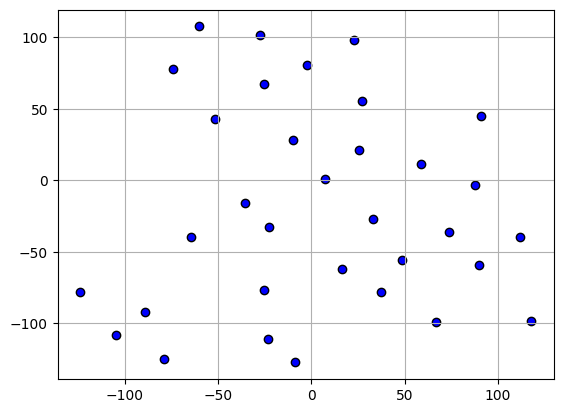

In [27]:
import matplotlib.pyplot as plt

# Extracting the x and y values from the array
x_values = vis_dims[:, 0]
y_values = vis_dims[:, 1]
plt.scatter(x_values, y_values, c='blue', marker='o', edgecolor='black')
plt.grid(True)
plt.show()

### 接著來分群

K-Means 是最常見的分群算法，看你想要分成幾群，算法就會將距離比較近的 vectors 歸類成一群

In [28]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(df["embeddings"].values)
n_clusters = 4 # 分四群

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['Cluster'] = kmeans.labels_

Text(0.5, 1.0, 'Clusters identified visualized in language 2d using t-SNE')

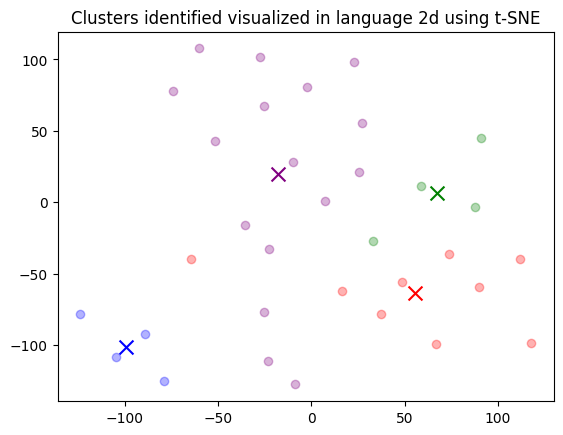

In [29]:
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue"]):
    xs = np.array(x)[df.Cluster == category]
    ys = np.array(y)[df.Cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

plt.title("Clusters identified visualized in language 2d using t-SNE")

## 透過 LLM 可幫每個群訂出一個主題(貼標)

In [30]:
rev_per_cluster = 3 # 每群挑5本書來餵給 LLM

for i in range(n_clusters):
    print(f"Cluster {i} 主題:", end=" ")

    reviews = "\n".join(
        df[df.Cluster == i]
        .title
        .sample(rev_per_cluster, random_state=42)
        .values
    )

    messages = [
      {
        "role": "user",
        "content": f'以下書籍描述有什麼共通性，請回答一個分類主題: \n\n 內容: {reviews} 主題: '
      }
    ]

    response = get_completion(messages)
    print(response)

    sample_cluster_rows = df[df.Cluster == i].sample(rev_per_cluster, random_state=42)
    for j in range(rev_per_cluster):
        print(" 書名: ", end=" ")
        print(sample_cluster_rows.title.values[j])
        # print(sample_cluster_rows.description.str[:70].values[j])

    print("-" * 100)

Cluster 0 主題: 這些書籍的共通性可以歸類為「科技與管理」。它們探討了在當前科技快速發展的背景下，如何運用數學、人工智慧和軟體測試等工具和方法來提升管理效率和決策能力。
 書名:  AI 時代的管理數學：使用 R語言實作
 書名:  AI世代：從政治哲學反思人工智慧的衝擊
 書名:  軟體測試實務 : 業界成功案例與高效實踐 [ I ]
----------------------------------------------------------------------------------------------------
Cluster 1 主題: 這些書籍的共通性可以歸類為「程式設計與人工智慧技術」。它們都涉及到程式語言、電腦運作原理以及與人工智慧相關的開發工具和技術。
 書名:  AI 時代從基本功下手 - 深入電腦底層運作原理
 書名:  圖解 Java 物件導向程式語言
 書名:  LangChain 開發手冊 -- OpenAI × LCEL 表達式 × Agent 自動化流程 × RAG 擴展模型知識 × 圖形資料庫 × LangSmith 除錯工具
----------------------------------------------------------------------------------------------------
Cluster 2 主題: 分類主題: **數據處理與自動化技術** 

這些書籍都集中在如何利用技術（如網路爬蟲、Python、Power Automate等）來進行數據收集、分析和自動化工作流程，適合希望提升數據處理能力和工作效率的讀者。
 書名:  文科生也可以輕鬆學會 Web Scraper 網路爬蟲與 Power Automate X Excel 大數據分析
 書名:  AI世代必備！Python × ChatGPT 高效率工作術：從網路爬蟲到辦公室自動化超實務
 書名:  Power Automate 自動化大全：串接 Excel、ChatGPT、SQL 指令，打造報表處理、網路爬蟲、資料分析超高效流程
--------------------------------------------------------------------------------------